# Vanishing Point Detection

## Setup

In [10]:
import cv2
import numpy as np

from vanishingpoint import *

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2
import extcolors

from colormap import rgb2hex

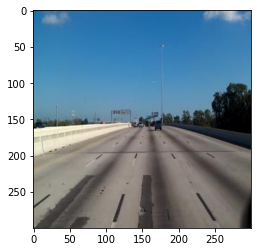

In [12]:
image_path = r"../train/source/video-18-frame-728.jpg"
image = plt.imread(image_path)
plt.imshow(image)
plt.show()

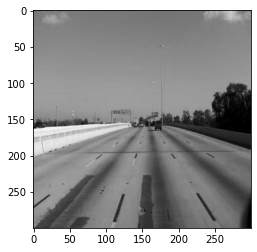

In [13]:
gray_img = convert_to_gray(image)
plt.imshow(gray_img, cmap='gray')
plt.show()

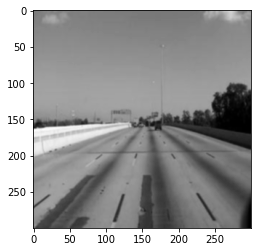

In [14]:
blured_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
plt.imshow(blured_img, cmap='gray')
plt.show()

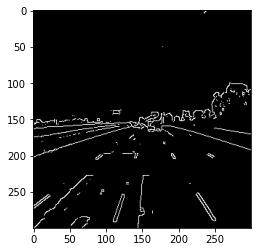

In [15]:
edges = get_edges(blured_img, 0.01)
plt.imshow(edges, cmap='gray')
plt.show()

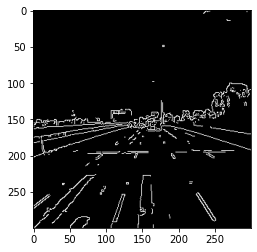

In [16]:
edges = get_edges(gray_img, 0.1)
plt.imshow(edges, cmap='gray')
plt.show()

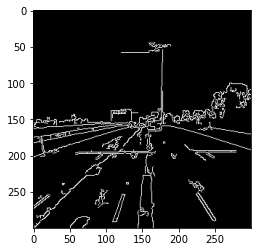

In [17]:
edges = get_edges(gray_img, 1)
plt.imshow(edges, cmap='gray')
plt.show()

## Extracting useful features

### Colors

The code for this subsections was taken from: https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e

In [19]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df

In [20]:
def exact_color(input_image, resize, tolerance, zoom):
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    #resize
    output_width = resize
    img = Image.open(input_image)
    if img.size[0] >= resize:
        wpercent = (output_width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((output_width,hsize), Image.ANTIALIAS)
        resize_name = 'resize_'+ input_image
        img.save(resize_name)
    else:
        resize_name = input_image
    
    #create dataframe
    img_url = resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 13)
    df_color = color_to_df(colors_x)
    
    #annotate text
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_precent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(resize_name)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2 = 160, -170, -170
    for c in list_color:
        if list_color.index(c) <= 5:
            y_posi += 180
            rect = patches.Rectangle((x_posi, y_posi), 360, 160, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+400, y = y_posi+100, s = c, fontdict={'fontsize': 190})
        else:
            y_posi2 += 180
            rect = patches.Rectangle((x_posi + 1000, y_posi2), 360, 160, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1400, y = y_posi2+100, s = c, fontdict={'fontsize': 190})

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    return plt.show()

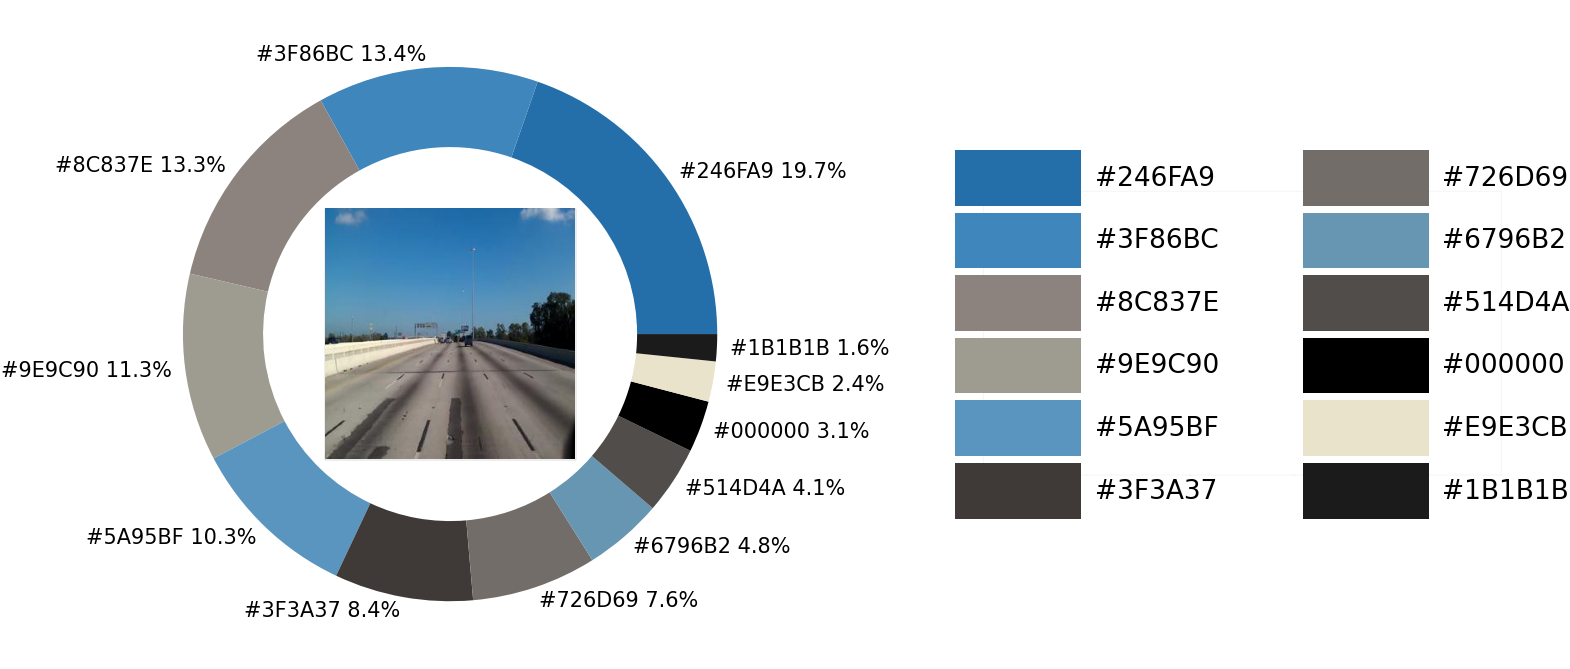

In [21]:
exact_color(image_path, 900, 8, 6)

---

### Road Extraction

In [22]:
def create_mask(image, hsv_lower, hsv_upper):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
    return mask

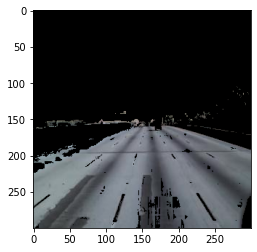

In [23]:
hsv_lower = np.array([0, 0, 50])
hsv_upper = np.array([255, 40, 175])

img = cv2.imread(image_path)
mask = create_mask(img, hsv_lower, hsv_upper)
result = cv2.bitwise_and(img, img, mask=mask)

plt.imshow(result)
plt.show()

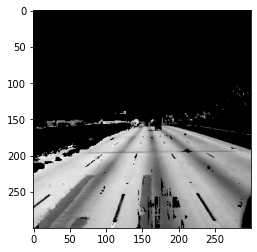

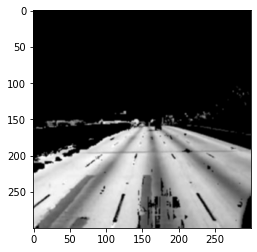

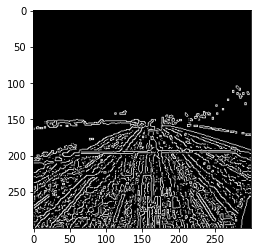

In [24]:
gray_img = convert_to_gray(result)
plt.imshow(gray_img, cmap='gray')
plt.show()

blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
plt.imshow(blur_img, cmap='gray')
plt.show()

edges = get_edges(blur_img, 0.1)
plt.imshow(edges, cmap='gray')
plt.show()

#### Testing

In [25]:
def edges_extraction(img, sigma):
    hsv_lower = np.array([0, 0, 50])
    hsv_upper = np.array([255, 40, 175])

    mask = create_mask(img, hsv_lower, hsv_upper)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    gray_img = convert_to_gray(masked_img)
    blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
    edges = get_edges(blur_img, sigma)
    return edges

In [26]:
def get_lines_new(img, sigma):
    edges = edges_extraction(img, sigma)
    lines = get_hough_lines(edges)
    if lines is not None:
        return [line[0] for line in lines]
    else:
        return []

In [27]:
def run(file_name, sigma, save=False):
    img = cv2.imread(file_name)

    name = file_name.split('/')[-1].split('.')[0] + time.strftime("_%H_%M")

    lines = get_lines_new(img, sigma)
    intersections = find_intersections(lines)
    v_point = find_vp(intersections, img.shape)

    if save:
        save_results(img, v_point, name)

    return v_point

In [28]:
path2data = '../train/source/'
path2res = '../res/'

p_sigma = 0.2

res_dict = {}

for f in tqdm(os.listdir(path2data)):
    try:
        res_dict[f] = run(os.path.join(path2data, f'{f}'),
                          p_sigma)
    except Exception as e:
        print(f)
        print(e)

write_to_json(path2res, res_dict)

 78%|████████████████████████████████▏        | 631/804 [00:07<00:02, 84.82it/s]

.ipynb_checkpoints
OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-9poqjr9l/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



100%|█████████████████████████████████████████| 804/804 [00:09<00:00, 81.23it/s]


In [94]:
# !python ./src/vanishingpoint.py --data ./train/source/ --ans ./res    
# !python ./evaluation_scripts/metrics.py --imgs './train/source' --gt './train/markup.json' --ans './res/answers.json'

 # What to do

This modification haven't increased the quality. 

Before: Mean: 10.473018279735532, median: 3.2488866699823657. 
Now: Mean: 10.051005003495208, median: 3.5561651787477153

To increase quality we need to understand our weaknesses. For this reason it's a good idea to select image with the highest error and study it.

In [5]:
import json

with open('../evaluation_scripts/metrics.json', 'r') as json_file:
    answers = json.load(json_file)

In [8]:
{k: v for k, v in sorted(answers.items(), key=lambda item: item[1], reverse=True)}

{'video-18-frame-728.jpg': 86.26728661001547,
 'video-18-frame-1561.jpg': 86.15822610413699,
 'video-18-frame-1069.jpg': 82.7782430645003,
 'video-18-frame-1337.jpg': 78.18587171829174,
 'video-18-frame-1274.jpg': 76.96195640727322,
 'video-18-frame-1553.jpg': 72.63204598663735,
 'video-18-frame-763.jpg': 70.26736406809383,
 'video-18-frame-220.jpg': 70.03631540983707,
 'video-18-frame-268.jpg': 69.69760295158562,
 'video-18-frame-727.jpg': 68.35915106715953,
 'video-18-frame-1068.jpg': 64.99606464759326,
 'video-18-frame-1470.jpg': 64.19073548861148,
 'video-18-frame-1275.jpg': 63.85646063442487,
 'video-18-frame-1466.jpg': 63.21477796756774,
 'video-18-frame-1059.jpg': 61.6725376104307,
 'video-18-frame-1566.jpg': 60.10450461507756,
 'video-18-frame-431.jpg': 59.73486044564411,
 'video-18-frame-1313.jpg': 58.154433269487015,
 'video-18-frame-433.jpg': 57.914061726972385,
 'video-18-frame-1264.jpg': 56.29036109443554,
 'video-18-frame-229.jpg': 55.51027474231148,
 'video-18-frame-1415